In [261]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
from pathlib import Path

In [244]:
fn = "Flames cut out-15"

In [267]:
#pip install svg.path
from svg.path import parse_path
from xml.dom.minidom import parse

# Parse the SVG file
dom = parse(str(Path.home() / "Downloads" / fn) + ".svg")

# Get the path data
path_strings = [path.getAttribute('d') for path 
                in dom.getElementsByTagName('path')]

# Parse the path data into a list of Path objects
paths = [parse_path(ps) for ps in path_strings]
len(paths)

1

In [268]:
# find boundingbox of entire shape
maxy = maxx = -1e8
miny = minx = 1e8

for path in paths:
    x0,y0,x1,y1 = path.boundingbox()

    if x0 < minx:
        minx = x0
    if x1 < minx:
        minx = x1
    if y0 < miny:
        miny = y0
    if y1 < miny:
        miny = y1
    if x0 > maxx:
        maxx = x0
    if x1 > maxx:
        maxx = x1
    if y0 > maxy:
        maxy = y0
    if y1 > maxy:
        maxy = y1
minx,miny,maxx,maxy

(1.9968974165378848, 2.0028698997293852, 530.7984169770227, 560.9700000000001)

In [272]:
type(paths[0])

svg.path.path.Path

In [269]:
W=H=600
Nsamples = 20 # number of sampling points along each path including start and end.
segments=[]
for path in paths:
    for p in path:
        x1,y1 = p.start.real,p.start.imag
        for i in range(Nsamples):
            x0,y0 = x1,y1
            pp = p.point((i+1)/Nsamples)
            x1,y1 = pp.real,pp.imag
#             segments.append((x0,y0,x1,y1,1))
            segments.append((W*(x0-minx)/(maxx-minx),H*(y0-miny)/(maxy-miny),
                             W*(x1-minx)/(maxx-minx),H*(y1-miny)/(maxy-miny),
                             1))
len(segments)

880

In [270]:
# plot segments in an output image, using their code.
def plot(segments,output):
    c=(0,0,0)

    for (x1,y1,x2,y2,code) in segments:
        if code == 0:
            w = 4
            dash = 0
        elif code ==1:
            w = 1
            dash = 0
        else:
            w = 1
            dashblack = 5
            dashwhite = 5
            dash = dashblack + dashwhite
        if x1 > x2:
            x1,x2 = x2,x1
            y1,y2 = y2,y1
        if dash:
            l = slen((x1,y1,x2,y2,code))
            n = l/dash
            dx = (x2-x1)/n
            ddx = dx * dashblack/dash
            dy = (y2-y1)/n
            ddy = dy * dashblack/dash
            n = int(n)+1
            for i in range(n):
                xx1 = int(x1 + dx * i + 0.5)
                xx2 = int(x1 + dx * i + ddx + 0.5)
                yy1 = int(y1 + dy * i + 0.5)
                yy2 = int(y1 + dy * i + ddy + 0.5)                    
                output = cv2.line(output, (xx1, yy1), (xx2, yy2), c, w)
        else:
            output = cv2.line(output, (int(x1+0.5), int(y1+0.5)), (int(x2+0.5), int(y2+0.5)), c, w)
    return output

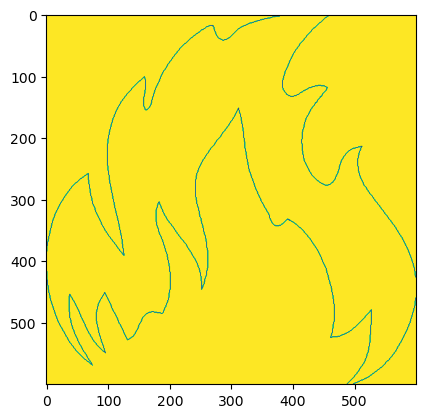

In [271]:
output = np.ones((W,H), np.uint8)*255
output = plot(segments,output)
f, ax = plt.subplots(1,1)
ax.imshow(output)

In [250]:
def slen(s): # segment length
    (x0,y0,x1,y1,c) = s
    return np.sqrt((x1-x0)**2 + (y1-y0)**2)

def plot_len(segments,x=0,y=0):
    l = 0.
    for (x0,y0,x1,y1,c) in segments:
        l += np.sqrt((x-x0)**2 + (y-y0)**2)
        l += slen((x0,y0,x1,y1,c))
        x = x1
        y = y1
    return l

In [251]:
segments = [s for s in segments if slen(s) > 0]

In [252]:
plot_len(segments)

4843.09205931992

In [253]:
# paper origin and dimension of pattern in mm
paper_w0 = 0
paper_h0 = 0
paper_size = 200

laser_power = 999

In [254]:
def seg2gcode(f,segments,shape,
              w0=paper_w0,h0=paper_h0,w=paper_size,h=paper_size, # origin and dimension of pattern in mm. fit to paper size
              laser_power = laser_power, # laser power for different codes. tune to paper thickness and color
             ):
    dw = w/shape[0]
    dh = h/shape[1]
    
    for (x1,y1,x2,y2,code) in segments:        
        l = slen((x1,y1,x2,y2,code)) # line length
       
        f.write(f"G0X{(x1*dw + w0):.3f}Y{(y1*dh + h0):.3f}\n")
        f.write(f"G1X{(x2*dw + w0):.3f}Y{(y2*dh + h0):.3f}S{laser_power}\n")

In [255]:
fnout = fn.replace(' ','_')+'.gcode'
f = open(fnout,'w')

In [256]:
header = f""";Header Start
;estimated_time(s): 60
;MAXX: {paper_size}
;MAXY: {paper_size}
;MINX: 0
;MINY: 0
;Header End


G92 X0 Y0 Z0
G90
G0 F3000
G1 F1500
M3 I
"""
f.write(header)

131

In [257]:
seg2gcode(f,segments,(W,H))

In [258]:
f.write("G1X0Y0S0\n")
f.close()

In [259]:
!cp {fnout} /Volumes/NO\ NAME/{fnout}